In [155]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [156]:
weight = [263.7, 261.1, 258.5, 258.7, 257.9, 257.1, 256.8, 254.3, 253.9, 251.9, 252.7]
fat = [33.7, 33.1, 32.6, 32.8, 32.5, 32.4, 32.4, 31.9, 31.9, 31.4, 31.6]
xdata = np.arange(len(ydata))

In [161]:
def f0(x, a):
    return a * np.ones_like(x)
def f1(x, a, b, c):
    return a + b*np.exp(-c*x)
def f2(x, a, b, c, d, e):
    return a + b*np.exp(-c*x) + d*np.exp(-e*x)
def f3(x, a, b, c, d, e, f, g):
    return a + b*np.exp(-c*x) + d*np.exp(-e*x) + f*np.exp(-g*x)
def f4(x, a, b, c, d, e, f, g, h, i):
    return a + b*np.exp(-c*x) + d*np.exp(-e*x) + f*np.exp(-g*x) + h*np.exp(-i*x)

def j0(x, a):
    jac = [np.ones_like(x)]
    return np.array(jac).T
def j1(x, a, b, c):
    jac = [np.ones_like(x),
           np.exp(-c*x),
           -b*x*np.exp(-c*x )]
    return np.array(jac).T
def j2(x, a, b, c, d, e):
    jac = [np.ones_like(x),
           np.exp(-c*x),
           -b*x*np.exp(-c*x ),
           np.exp(-e*x),
           -d*x*np.exp(-e*x )]
    return np.array(jac).T
def j3(x, a, b, c, d, e, f, g):
    jac = [np.ones_like(x),
           np.exp(-c*x),
           -b*x*np.exp(-c*x ),
           np.exp(-e*x),
           -d*x*np.exp(-e*x ),
           np.exp(-g*x),
           -f*x*np.exp(-g*x )]
    return np.array(jac).T
def j4(x, a, b, c, d, e, f, g, h, i):
    jac = [np.ones_like(x),
           np.exp(-c*x),
           -b*x*np.exp(-c*x ),
           np.exp(-e*x),
           -d*x*np.exp(-e*x ),
           np.exp(-g*x),
           -f*x*np.exp(-g*x ),
           np.exp(-i*x),
           -h*x*np.exp(-i*x )]
    return np.array(jac).T

In [158]:
b0 = np.array([[0, np.inf]]).T
b1 = np.array([[0, np.inf], [-np.inf, np.inf], [0, np.inf]]).T
b2 = np.array([[0, np.inf], [-np.inf, np.inf], [0, np.inf], [-np.inf, np.inf], [0, np.inf]]).T
b3 = np.array([[0, np.inf], [-np.inf, np.inf], [0, np.inf], [-np.inf, np.inf], [0, np.inf], [-np.inf, np.inf], [0, np.inf]]).T
b4 = np.array([[0, np.inf], [-np.inf, np.inf], [0, np.inf], [-np.inf, np.inf], [0, np.inf], [-np.inf, np.inf], [0, np.inf], [-np.inf, np.inf], [0, np.inf]]).T

In [169]:
wopt0, _ = curve_fit(f0, xdata, weight, bounds=b0, jac=j0, maxfev=1000000)
wopt1, _ = curve_fit(f1, xdata, weight, bounds=b1, jac=j1, maxfev=1000000)
wopt2, _ = curve_fit(f2, xdata, weight, bounds=b2, jac=j2, maxfev=1000000)
wopt3, _ = curve_fit(f3, xdata, weight, bounds=b3, jac=j3, maxfev=1000000)
wopt4, _ = curve_fit(f4, xdata, weight, bounds=b4, jac=j4, maxfev=1000000)

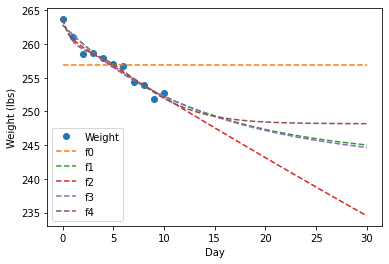

In [170]:
x = np.linspace(0, 3 * xdata[-1], 100)
plt.plot(xdata, weight, 'o', label='Weight')
plt.plot(x, f0(x, *wopt0), '--', label='f0')
plt.plot(x, f1(x, *wopt1), '--', label='f1')
plt.plot(x, f2(x, *wopt2), '--', label='f2')
plt.plot(x, f3(x, *wopt3), '--', label='f3')
plt.plot(x, f4(x, *wopt4), '--', label='f4')
plt.xlabel('Day')
plt.ylabel('Weight (lbs)')
plt.legend()
plt.show()

In [171]:
fopt0, _ = curve_fit(f0, xdata, fat, bounds=b0, jac=j0, maxfev=1000000)
fopt1, _ = curve_fit(f1, xdata, fat, bounds=b1, jac=j1, maxfev=1000000)
fopt2, _ = curve_fit(f2, xdata, fat, bounds=b2, jac=j2, maxfev=1000000)
fopt3, _ = curve_fit(f3, xdata, fat, bounds=b3, jac=j3, maxfev=1000000)
fopt4, _ = curve_fit(f4, xdata, fat, bounds=b4, jac=j4, maxfev=1000000)

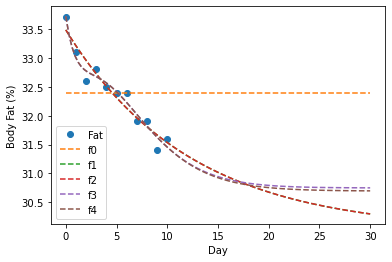

In [174]:
x = np.linspace(0, 3 * xdata[-1], 100)
plt.plot(xdata, fat, 'o', label='Fat')
plt.plot(x, f0(x, *fopt0), '--', label='f0')
plt.plot(x, f1(x, *fopt1), '--', label='f1')
plt.plot(x, f2(x, *fopt2), '--', label='f2')
plt.plot(x, f3(x, *fopt3), '--', label='f3')
plt.plot(x, f4(x, *fopt4), '--', label='f4')
plt.xlabel('Day')
plt.ylabel('Body Fat (%)')
plt.legend()
plt.show()

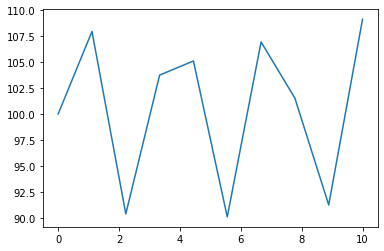

In [175]:
xdata = np.linspace(0, 10, 10)
ydata = 100 + 10*np.sin(2*xdata)
plt.plot(xdata, ydata)
plt.show()

In [178]:
curve_fit(f4, xdata, ydata, maxfev=1000000)

(array([ 1.00012362e+02, -2.26948465e+02, -1.14400731e+00,  1.07836014e+02,
        -1.14400649e+00,  1.19117223e+02, -1.14400322e+00,  6.05059969e-59,
        -1.38656301e+01]),
 array([[ 9.23096590e+001, -1.26582535e+004, -1.82151990e+001,
         -3.83105163e+004, -1.97776493e+000,  5.09674308e+004,
         -3.29184681e+001, -5.53754202e-051, -9.15244284e+006],
        [-9.20636480e+003, -4.14880879e+007,  2.59003270e+004,
          2.17359064e+008,  6.20152165e+004, -1.75870863e+008,
         -6.78936804e+003,  1.44573755e-047,  2.38951232e+010],
        [-1.31222849e+001,  1.78059035e+004,  2.13814996e+001,
          1.11055513e+005,  3.27174355e+001, -1.28860887e+005,
          1.11237942e+001,  2.57541228e-051,  4.25663859e+006],
        [-1.41175498e+004,  1.38749950e+008,  1.13001542e+005,
          1.10949315e+007,  2.34711721e+005, -1.49844146e+008,
          2.82074299e+003, -3.89417917e-048, -6.43628876e+009],
        [ 9.94232230e+000,  4.11546067e+004,  3.03563969e+001